[View in Colaboratory](https://colab.research.google.com/github/sthalles/blog-resources/blob/master/eager_gan/Generative_Adversarial_Nets_Eager.ipynb)

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
tf.enable_eager_execution()
import matplotlib.pyplot as plt
from keras.datasets import cifar10


1.8.0


Using TensorFlow backend.


In [2]:
# x_train, x_test: uint8 array of RGB image data with shape (num_samples, 3, 32, 32).
# y_train, y_test: uint8 array of category labels (integers in range 0-9) with shape (num_samples,).
(X_train, y_train), (X_test, y_test) = cifar10.load_data() 
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train data shape: (50000, 32, 32, 3)
Train labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


Number of classes: 10


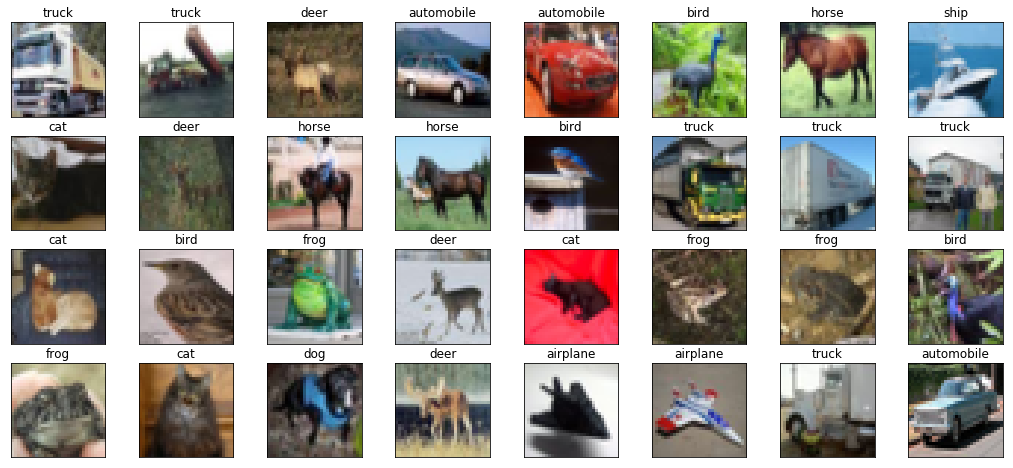

In [3]:
cifar_10 = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

n_classes = len(cifar_10)
print("Number of classes:", n_classes)


fig = plt.figure(figsize=(18,8))
n_columns = 8
n_rows = 4

for i in range(1,n_columns*n_rows+1):
  fig.add_subplot(n_rows, n_columns, i)
  plt.imshow(X_train[i])
  plt.title(cifar_10[y_train[i]])
  # Turn off tick labels
  plt.xticks([])
  plt.yticks([])
plt.show()

In [4]:
tfe = tf.contrib.eager

In [5]:
class SelfAttention(tf.keras.Model):
  def __init__(self, number_of_filters):
    super(SelfAttention, self).__init__(number_of_filters)
    
    self.f = tf.keras.layers.Conv2D(number_of_filters/8, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.g = tf.keras.layers.Conv2D(number_of_filters/8, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.h = tf.keras.layers.Conv2D(number_of_filters, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.gamma = tfe.Variable(0.0, dtype=tf.float32) 
    self.flatten = tf.keras.layers.Flatten()
    
  def call(self, x):
    input_shape = tf.shape(x)
    f = self.f(x)
    g = self.g(x)
    h = self.h(x)
    
    f_flatten = self.flatten(f)
    g_flatten = self.flatten(g)
    h_flatten = self.flatten(h)
    
#     print("f_flatten:", f_flatten.shape)
#     print("g_flatten:", g_flatten.shape)
#     print("h_flatten:", h_flatten.shape)
    
    s = tf.matmul(g_flatten, f_flatten, transpose_b=True)
    B = tf.nn.softmax(s)
    
#     print("s:",s.shape)
#     print("B:",B.shape)
    o = tf.matmul(B, h_flatten)
    
    y = self.gamma * o + self.flatten(x)
    return tf.reshape(y, input_shape)

In [6]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    # define the generator's layers
    
    self.fc1 = tf.keras.layers.Dense(units=4*4*512, activation=None)
    
    # BN + ReLU
    self.bn1 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation1 = tf.keras.layers.Activation(activation='relu')
    
    # Deconvolution layer. Resulting image shape: (batch, 8, 8, 256)
    self.transp_conv1 = tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn2 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation2= tf.keras.layers.Activation(activation='relu')
    
    # resulting shape: (batch, 16, 16, 128)
    self.transp_conv2 = tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn3 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation3= tf.keras.layers.Activation(activation='relu')
    
    self.attention = SelfAttention(128)
    
    # resulting shape: (batch, 32, 32, 3)
    self.transp_conv3 = tf.keras.layers.Conv2DTranspose(3, 5, strides=2, padding="SAME", activation=None)
    self.out = tf.keras.layers.Activation(activation='tanh')
    
  def call(self,z, is_training):

    fc1 = self.fc1(z)
    fc1_reshaped = tf.reshape(fc1, (-1,4,4,512))

    bn1 = self.bn1(fc1_reshaped, training=is_training)
    activation1 = self.activation1(bn1)

    trans_conv1 = self.transp_conv1(activation1) # output shape [None,8,8,256]
    bn2 = self.bn2(trans_conv1, training=is_training)
    activation2 = self.activation2(bn2)

    transp_conv2 = self.transp_conv2(activation2) # output shape [None,16,16,128]
    bn3 = self.bn3(transp_conv2, training=is_training)
    activation3 = self.activation3(bn3)
    
    attention = self.attention(activation3)
    
    transp_conv3 = self.transp_conv3(attention) # output shape [None,32,32,3]
    output = self.out(transp_conv3)
    
    return output

In [7]:
class Discriminator(tf.keras.Model):
  def __init__(self, alpha):
    super(Discriminator, self).__init__()
    
    self.conv1 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='SAME', activation=None)
    self.activation1 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.attention = SelfAttention(64)
  
    self.conv2 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='SAME', activation=None)
    self.bn1 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation2 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.conv3 = tf.keras.layers.Conv2D(256, 5, strides=2, padding='SAME', activation=None)
    self.bn2 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation3 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(units=1, activation=None)
    self.out = tf.keras.layers.Activation(activation='sigmoid')
  
  def call(self, inputs, is_training):

    conv1 = self.conv1(inputs)
    activation1 = self.activation1(conv1)
    
    attention = self.attention(activation1)
    
    conv2 = self.conv2(activation1)
    bn1 = self.bn1(conv2, training=is_training)
    activation2 = self.activation2(bn1)
    
    conv3 = self.conv3(activation2)
    bn2 = self.bn2(conv3, training=is_training)
    activation3 = self.activation3(bn2)
    
    flat = self.flatten(activation3)
    logits = self.fc1(flat)
    out = self.out(logits)
    return out, logits

In [8]:
z_size = 100
learning_rate = 0.0002
batch_size = 128
alpha = 0.2
beta1 = 0.5
smooth=0.1

In [9]:
generator_net = Generator()
discriminator_net = Discriminator(alpha=alpha)

In [10]:
def discriminator_loss(d_logits_real, d_logits_fake, smooth=0.1):

  
  # for the real image from the training set, we want them to be classified as positives,  
  # so we want their labels to be all ones. 
  # notice here we use label smoothing for helping the discriminator to generalize better. 
  # Label smoothing works by avoiding the classifier to make extreme predictions when extrapolating.
  d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))

  # for the fake images produced by the generator, we want the discriminator to classify them as false images,
  # so we set their labels to be all zeros.
  d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

  d_loss = d_loss_real + d_loss_fake
  return d_loss

In [11]:
def generator_loss(d_logits_fake, d_model_fake):
  
  # since the generator wants the discriminator to output 1s for its images, it uses the discriminator logits for the
  # fake images and assign labels of 1s to them.
  g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
  return g_loss

In [12]:
global_counter = tf.train.get_or_create_global_step()
generator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

In [13]:
def normalizer(image, label):
  image = 2 * tf.to_float(image) / 255 - 1.
  return image, label

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(normalizer)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)

In [15]:
def display_images(dataset, figsize=(6,6), denomalize=True):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=figsize,)
    for ii, ax in enumerate(axes.flatten()):
        img = dataset[ii,:,:,:]
        if denomalize:
            img = ((img + 1)*255 / 2).astype(np.uint8) # Scale back to 0-255
        ax.imshow(img, aspect='equal')
      
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

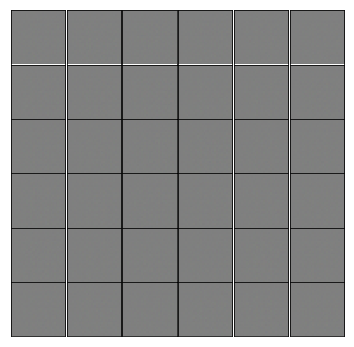

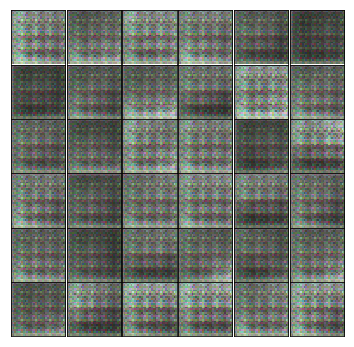

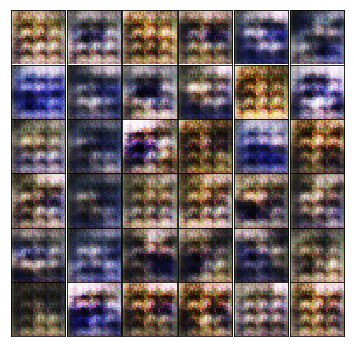

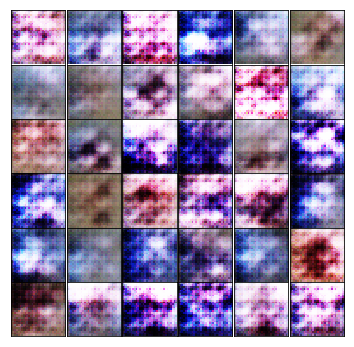

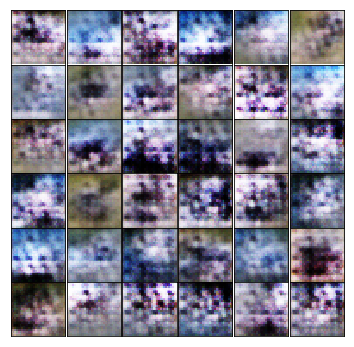

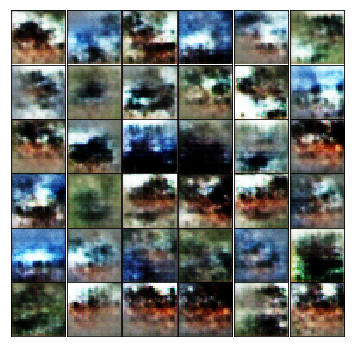

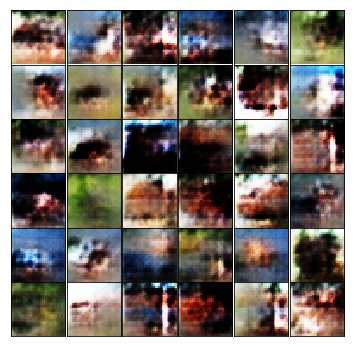

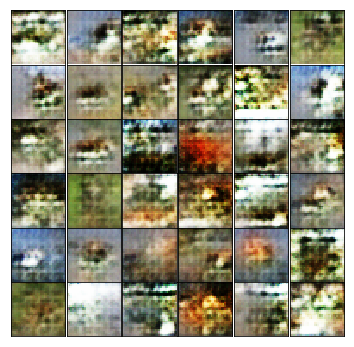

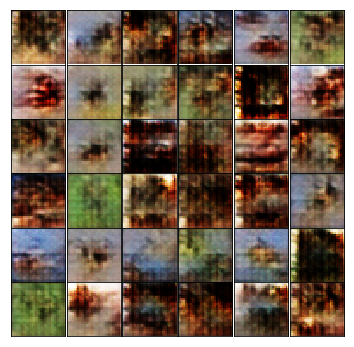

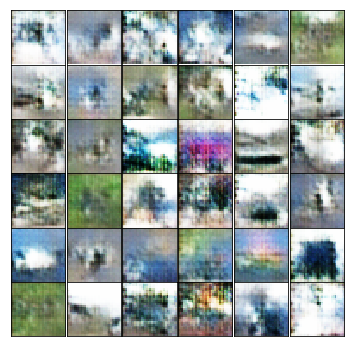

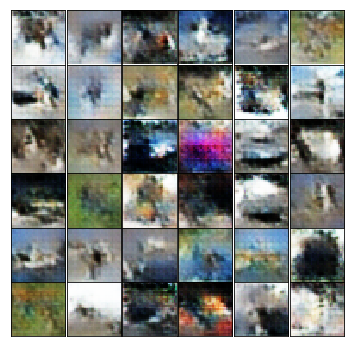

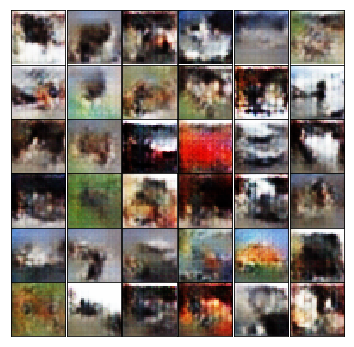

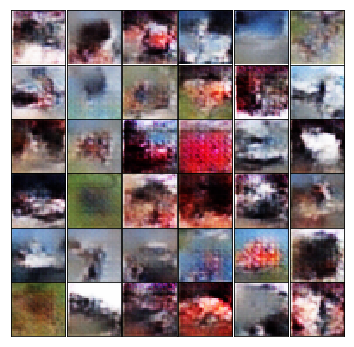

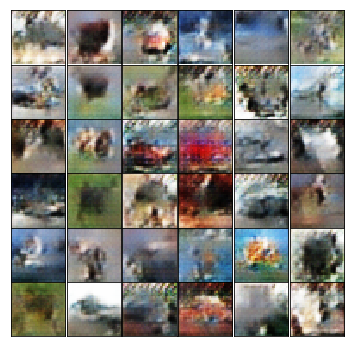

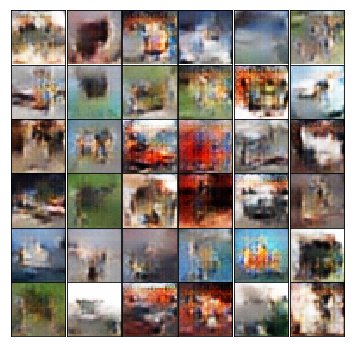

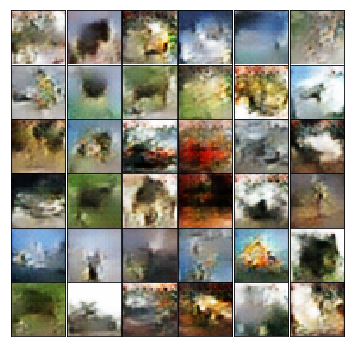

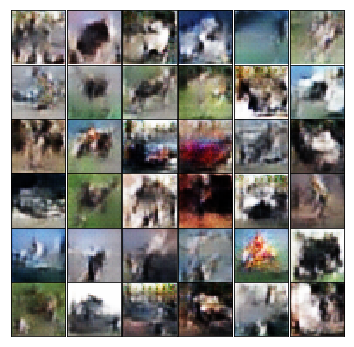

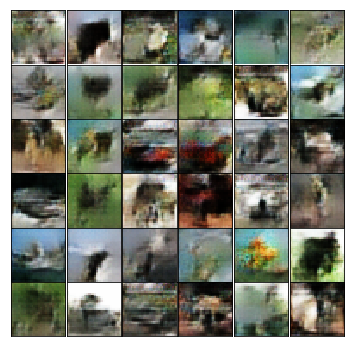

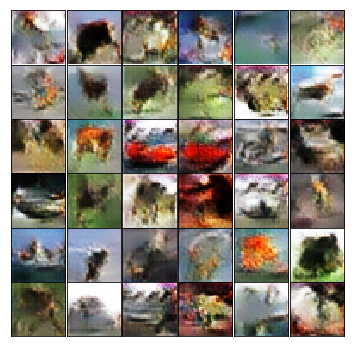

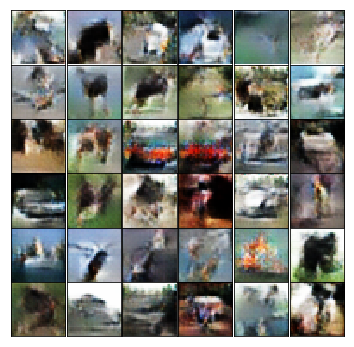

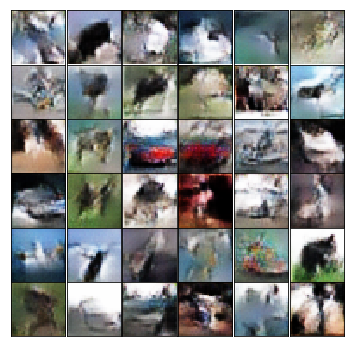

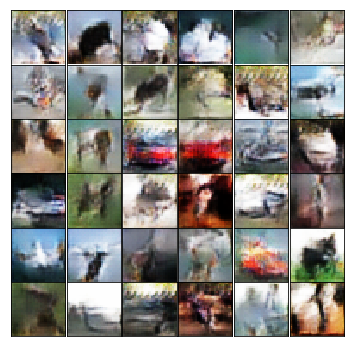

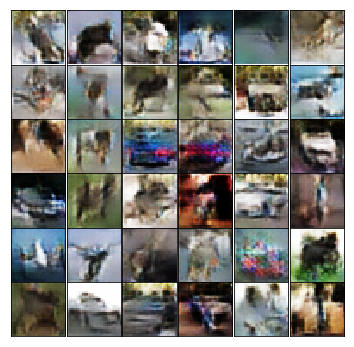

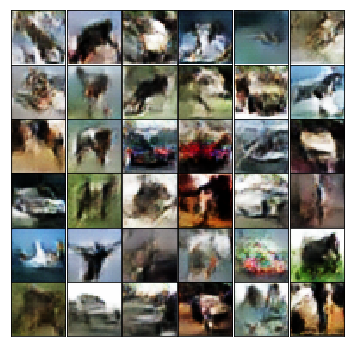

In [ ]:
# generate sample noise for evaluation
fake_input_test = tf.random_uniform(shape=(36, z_size),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)

for counter, (batch_real_images, batch_real_labels) in enumerate(train_dataset):
  fake_input = tf.random_uniform(shape=(batch_size, z_size),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)
  
  
  batch_real_images = tf.to_float(batch_real_images)
  with tf.GradientTape(persistent=True) as tape:
    
    # run the generator with the random noise batch
    g_model = generator_net(fake_input, is_training=True)
    
    # run the discriminator with real input images
    d_model_real, d_logits_real = discriminator_net(batch_real_images, is_training=True)
      
    # run the discriminator with fake input images (images from the generator)
    d_model_fake, d_logits_fake = discriminator_net(g_model, is_training=True)
    
    # compute the generator loss
    gen_loss = generator_loss(d_logits_fake, d_model_fake)
    
    # compute the discriminator loss
    dis_loss = discriminator_loss(d_logits_real, d_logits_fake, smooth)
    
    #print("Generator loss:", gen_loss, "Discriminator loss:", dis_loss)
   
  if counter % 300 == 0:
    generated_samples = generator_net(fake_input_test, is_training=False)
    display_images(generated_samples.numpy())
    
  discriminator_grads = tape.gradient(dis_loss, discriminator_net.variables)
  generator_grads = tape.gradient(gen_loss, generator_net.variables)
  
  discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator_net.variables), global_step=global_counter)
  generator_optimizer.apply_gradients(zip(generator_grads, generator_net.variables), global_step=global_counter)
  
  counter += 1